In [138]:
from gwpy.timeseries import TimeSeries as gwpy_TimeSeries

filename = "H-H1_GWOSC_4KHZ_R1-1126259447-32.hdf5"
# filename = 'H-H1_GWOSC_4KHZ_R1-1267963136-32.hdf5'
# filename = 'H-H1_GWOSC_4KHZ_R1-1267149494-32.hdf5'


# Note the format argument (see doc)
data = gwpy_TimeSeries.read("./GW_Events/" + filename, format="hdf5.gwosc")
print(data)

TimeSeries([9.06730891e-21, 2.01178871e-20, 3.71290472e-20, ...,
            5.32101440e-20, 4.74831535e-20, 7.76456828e-20]
           unit: dimensionless,
           t0: 1126259447.0 s,
           dt: 0.000244140625 s,
           name: Strain,
           channel: None)


ts = 0.000244140625s, sample rate = 4096.0Hz
[9.06730891e-21 2.01178871e-20 3.71290472e-20 ... 5.32101440e-20
 4.74831535e-20 7.76456828e-20]
Duration 32
GPSstart 1126259447


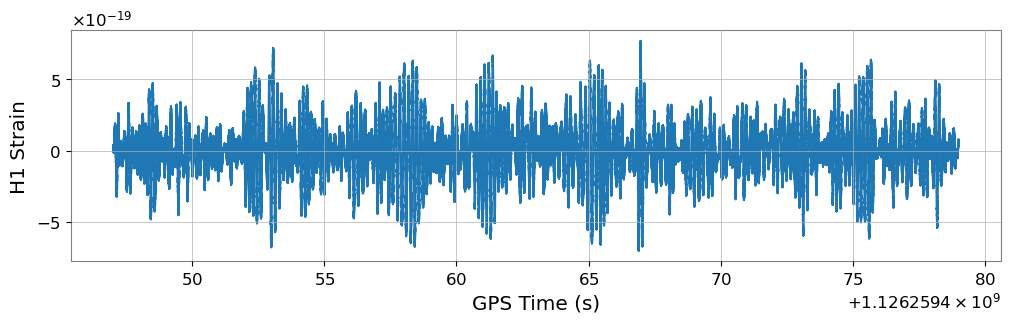

In [139]:
import h5py
import matplotlib.pyplot as plt 
import numpy as np

dataFile = h5py.File("./GW_Events/" + filename, 'r')

#--------------------
# Read in strain data
#--------------------
strain = dataFile['strain']['Strain']
ts = dataFile['strain']['Strain'].attrs['Xspacing']
print(f"ts = {ts}s, sample rate = {1/ts}Hz")
print(strain[()])

#-------------------------
# Print out some meta data
#-------------------------
metaKeys = dataFile['meta'].keys()
meta = dataFile['meta']
#for key in metaKeys:
#    print(key, meta[key])
print("Duration", meta["Duration"][()])
print("GPSstart", meta["GPSstart"][()])

#---------------------
# Create a time vector
#---------------------
gpsStart = meta['GPSstart'][()]
duration = meta['Duration'][()]
gpsEnd   = gpsStart + duration

time = np.arange(gpsStart, gpsEnd, ts)

#---------------------
# Plot the time series
#---------------------
plt.figure(figsize=(12, 3))
plt.plot(time, strain[()])
plt.xlabel('GPS Time (s)')
plt.ylabel('H1 Strain')
plt.show()

### FFT

Text(0, 0.5, 'Strain / Hz')

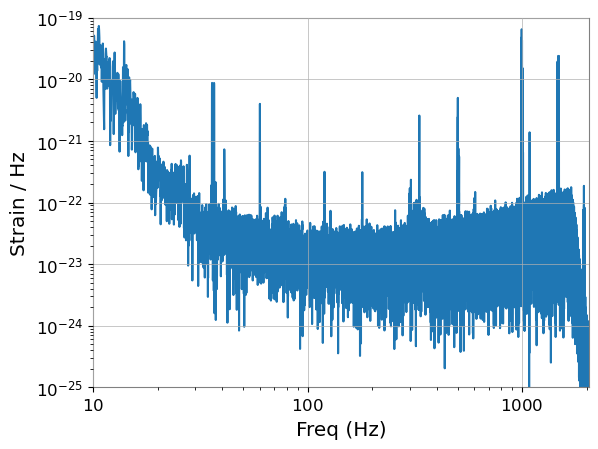

In [140]:
# Sampling frequency
fs = int(1.0 / ts)

#-----------------------------
# Extract a part of the signal
#-----------------------------
length     = 32     # Length in second
numsamples = int(length / ts)
startIndex = np.min(np.nonzero(gpsStart < time))
time_seg   = time[startIndex:(startIndex+numsamples)]
strain_seg = strain[startIndex:(startIndex+numsamples)]

#------------------------------------------
# Apply a Blackman Window, and plot the FFT
#------------------------------------------
window          = np.blackman(strain_seg.size)
windowed_strain = strain_seg * window
freq_domain     = np.fft.rfft(windowed_strain) / fs
freq            = np.fft.rfftfreq(len(windowed_strain)) * fs    
plt.loglog(freq, abs(freq_domain))
plt.axis([10, fs/2.0, 1e-25, 1e-19])
plt.grid('on')
plt.xlabel('Freq (Hz)')
plt.ylabel('Strain / Hz')

Text(0, 0.5, 'Strain / Hz')

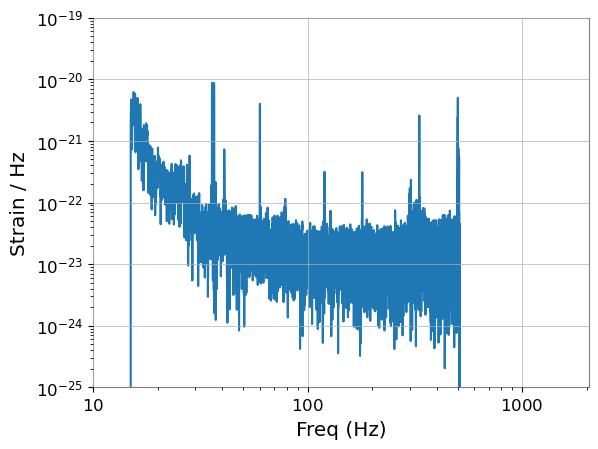

In [141]:
flow=15
fhigh=512

for i in range(len(freq)):
    if (freq[i]<flow) or (freq[i]>fhigh):
        freq_domain[i]=0

plt.loglog(freq, abs(freq_domain))
plt.axis([10, fs/2.0, 1e-25, 1e-19])
plt.grid('on')
plt.xlabel('Freq (Hz)')
plt.ylabel('Strain / Hz')

131071
131071


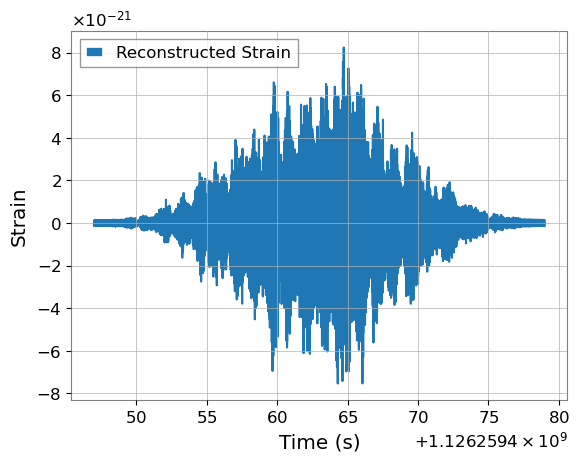

In [148]:
time_domain = np.fft.irfft(freq_domain * fs, n=len(windowed_strain))

print(len(time_seg))
print(len(time_domain))

# Plot the reconstructed strain signal
plt.plot(time_seg, time_domain, label="Reconstructed Strain")
plt.legend()
plt.xlabel("Time (s)")
plt.ylabel("Strain")
plt.grid(True)
plt.show()

In [149]:
from pycbc.types import TimeSeries, FrequencySeries
import math
import lal
import lalsimulation as lalsim
import random as rnd
import copy
import time 

from pycbc.filter import match as simple_match, optimized_match
from pycbc.psd import aLIGOZeroDetHighPower
from pycbc.waveform.utils import coalign_waveforms

def chirp_mass_function(masses:list)->float:

    return ((masses[0]*masses[1])**(3/5))/((masses[0]+masses[1])**(1/5))


def eff_spin_function(masses:list, spins:list)->float:

    return (spins[0]*masses[0]+spins[1]*masses[1])/(masses[0]+masses[1])


class params: # Class with all the basic information mandatory to simulate a GW
    def __init__(self, masses:tuple, spin1:tuple = (0,0,0) ,spin2:tuple= (0,0,0), r: float = 1e6 * lal.PC_SI,
                  incl:float = 0, phiRef:float = 0, longAscNodes:float=0, ecc:float = 0, meanPerAno:float = 0):
        # Atributo de instancia (Se vincula a la instancia)
        self.m1: float = masses[0] # Mass of the first Black Hole
        self.m2: float = masses[1] # Mass of the second Black Hole
        self.s1x:float = spin1[0] # First Component of the dimensionless spin parameter of the first Black Hole
        self.s1y:float = spin1[1] # Second Component of the dimensionless spin parameter of the first Black Hole
        self.s1z:float = spin1[2] # Third Component of the dimensionless spin parameter of the first Black Hole
        self.s2x:float = spin2[0] # First Component of the dimensionless spin parameter of the second Black Hole
        self.s2y:float = spin2[1] # Second Component of the dimensionless spin parameter of the second Black Hole
        self.s2z:float = spin2[2] # Third Component of the dimensionless spin parameter of the second Black Hole
        self.distance:float = r # Distance to the binary system
        self.inclination:float = incl # Angle of inclination of the system with respect to the earth
        self.phiRef:float = phiRef
        self.longAscNodes:float = longAscNodes
        self.eccentricity:float = ecc # Eccentricity of the binary system
        self.meanPerAno : float = meanPerAno # Parameter for the simulation of a system with eccentricity


    def Q(self) -> float: # Chirp Mass of the binary system
        return self.m1/self.m2


    def chirp_mass(self) -> float: # Chirp Mass of the binary system
        return chirp_mass_function([self.m1, self.m2])
    

    def eff_spin(self) -> float: # Effective Spin Parameter of the binary system
        return eff_spin_function([self.m1, self.m2], [self.s1z, self.s2z])
    
    
    def cambiar_valor_paso(self, n_param: int, h:float, a:float) -> None: # Function to sum a step to some parameter, useful to obtain the derivative
        param_keys = list(self.__dict__.keys())
        param_values = list(self.__dict__.values())
        atributo = param_keys[n_param]
        
        setattr(self, atributo, param_values[n_param]+a*h)

    def __str__(self) -> str: # String to format how does print(params) work
        return f"mass1: {self.m1} | mass2: {self.m2} | spin1: {self.s1x, self.s1y, self.s1z}| spin2: {self.s2x, self.s2y, self.s2z}, | distance: {self.distance}, |inclination: {self.inclination}, |phiRef: {self.phiRef}, |longAscNodes: {self.longAscNodes}, |eccentricity: {self.eccentricity}| meanPerAno: {self.meanPerAno}"
    

In [150]:
def simulationTD_IMRPhenomTPHM(parameters: params, delta_T:float, f_min:float, f_ref:float)->tuple:

    Approximant = "IMRPhenomTPHM"

    # Modes
    mode_list = [[2, 2], [2, -2]]

    # Create the waveform parameters structure
    waveform_params = lal.CreateDict()

    mode_array = lalsim.SimInspiralCreateModeArray()
    for l, m in mode_list:
        lalsim.SimInspiralModeArrayActivateMode(mode_array, l, m)
    lalsim.SimInspiralWaveformParamsInsertModeArray(waveform_params, mode_array)


    with lal.no_swig_redirect_standard_output_error():
    # Generate the waveform
        hplus, hcross = lalsim.SimInspiralChooseTDWaveform(**parameters.__dict__,
        deltaT=delta_T, f_min=f_min, f_ref=f_ref, params=waveform_params, approximant=lalsim.GetApproximantFromString(Approximant)
        )

    # Extract time series for both plus (h_plus) and cross (h_cross) polarizations
    h_plus = hplus.data.data
    h_cross = hcross.data.data 
    time = np.arange(len(h_plus)) * delta_T

    return h_plus, h_cross, time # The data is returned as Numpy arrays, we lost information of the epoch, etc which we won't use in this example

In [151]:
from pycbc.psd import welch

def perform_match(hnr, hap, f_lower, f_high, optimized = False, return_phase = False)->tuple:
    FD = isinstance(hnr, FrequencySeries)
    if not FD: 
        hnr, hap = hnr.real(), hap.real()
    
    # Match signal sizes
    length = max(len(hnr), len(hap))
    hnr.resize(length); hap.resize(length)

    # Compute PSD
    if FD: 
        delta_f = hnr.delta_f
    else:
        delta_f = 1/hnr.duration
        length = length//2 + 1
    
    psd = aLIGOZeroDetHighPower(length, delta_f, f_lower)
    
    # Compute Match
    match_kwargs = dict(vec1 = hnr, vec2 = hap, psd = psd, low_frequency_cutoff = f_lower, high_frequency_cutoff = f_high, return_phase = return_phase)
    return optimized_match(**match_kwargs) if optimized else simple_match(**match_kwargs, subsample_interpolation = True)

In [159]:
mass1_target = 61.5 * lal.MSUN_SI
mass2_target = 27.9 * lal.MSUN_SI

masses_target = (mass1_target, mass2_target)
r_generic = 92e6 * lal.PC_SI

spin1_target = (0,0.0,0.0)
spin2_target = (0,0,0.0)

parameters_target:params = params(masses_target, spin1_target, spin2_target, r = r_generic)
delta_T = 1.0/4096.0 
f_min = 15
f_max = 512
f_ref = f_min

hp_target, hc_target, time_target = simulationTD_IMRPhenomTPHM(parameters_target, delta_T, f_min, f_ref)

# Convert the data obtained from a numpy array to a PyCBC TimeSeries
hp_target = TimeSeries(hp_target, delta_t=delta_T)

0.9432408213270613


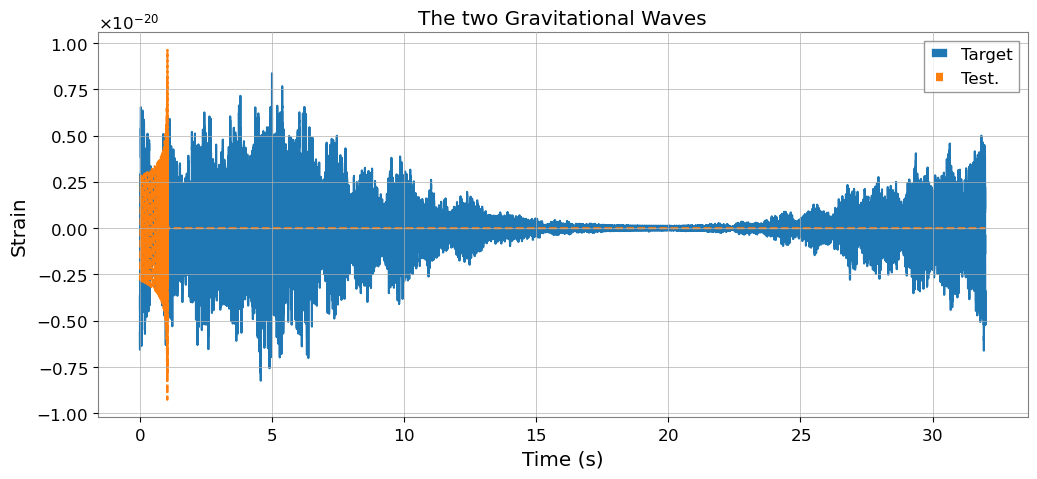

In [160]:
strain_data = TimeSeries(time_domain, delta_t=ts)

match,_ = perform_match (strain_data, hp_target, f_lower=f_min, f_high=f_max, optimized = True, return_phase = False)
print(1-match)

# Waveforms Coaligned 
h1_aligned, h2_aligned = coalign_waveforms(strain_data, hp_target)

# Plot of the coaligned waveforms
plt.figure(figsize=(12, 5))

plt.plot(h1_aligned.sample_times.data, h1_aligned.data, label = f'Target')
plt.plot(h2_aligned.sample_times.data, h2_aligned.data, label = f'Test.', linestyle='dashed')
plt.title(f'The two Gravitational Waves')
plt.xlabel('Time (s)')
plt.ylabel('Strain')

plt.legend()
plt.show()
